# Using Covalent with PennyLane

[PennyLane](https://pennylane.ai/) is a popular Python library for differentiable programming of quantum computers that is well suited for quantum machine learning tasks. In this tutorial, we will demonstrate how to integrate Covalent with PennyLane for a simple hybrid quantum-classical optimization task. This is based on the PennyLane demo: [Plugins and Hybrid Computation](https://pennylane.ai/qml/demos/tutorial_plugins_hybrid.html).

In essence, we will build a simple photonic circuit with two qumodes (i.e., photonic analog of qubits, which are referred to as "wires" in PennyLane) using PennyLane's Strawberry Fields plugin. The circuit is initialized with the state $\ket{1,0}$ and contains a beamsplitter with two free parameters $\theta$ and $\phi$, which together determine the transmission and reflection amplitudes. In addition, we will build another one-qubit quantum circuit comprising two rotation gates with fixed angles. The goal is to optimize the beamsplitter parameters $(\theta, \phi)$ such that the expectation value of the photon number in the second wire of the photonic circuit is close to the expectation value of measurements of the qubit circuit in the computational basis. In a realistic hybrid implementation, the expectation values would be measured with quantum computers, whereas the optimization would be done on a classical computer. We will see how to use Covalent to manage such hybrid workflows. We refer the reader to the original PennyLane demo for more details on the quantum circuits.

In addition to Covalent, this tutorial uses PennyLane as well as its Strawberry Fields plugin. So we first do the following installations.

In [ ]:
# !pip install cova
# !pip install pennylane
# !pip install pennylane-sf

Then we start the Covalent server.

In [ ]:
# !covalent start
# !covalent purge

Finally, let us import the necessary libraries.

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import covalent as ct
import matplotlib.pyplot as plt

## Construct the workflow

We can now start constructing our workflow for the hybrid optimization task. First, we initialize two devices with PennyLane, one for the photon-redirection circuit and the other for a qubit-rotation circuit, which is needed for the optimization later. 

In [2]:
dev_fock = qml.device('strawberryfields.fock', wires=2, cutoff_dim=10)
dev_qubit = qml.device('default.qubit', wires=1)

With the devices initialized, we construct the corresponding quantum nodes by defining the quantum circuits and adding the `qnode` decorator onto them. Note that the qubit-rotation circuit is a simple one-qubit quantum circuit which composes of two rotation gates $R_X$ and $R_Y$, parameterized by two angles $\phi_1$ and $\phi_2$, respectively. To use Covalent in this workflow, we simply transform them into `Electron` objects by adding the `electron` decorator on top.

In [3]:
@ct.electron
@qml.qnode(dev_fock)
def photon_redirection(params):
    qml.FockState(1, wires=0)
    qml.Beamsplitter(params[0], params[1], wires=[0,1])
    return qml.expval(qml.NumberOperator(1))

@ct.electron
@qml.qnode(dev_qubit)
def qubit_rotation(phi1, phi2):
    qml.RX(phi1, wires=0)
    qml.RY(phi2, wires=0)
    return qml.expval(qml.PauliZ(0))

.. note:: If you were to run the workflow on real quantum hardwares, you can specify the `executor` inside the `electron` decorator, i.e., `@ct.electron(executor=quantum_executor)`, where `quantum_executor` might be one of the quantum devices that will be supported in Covalent in the future.

Now the optimization can be done solely on a classical computer, making this a hybrid workflow. We will first fix the qubit-rotation angles to be e.g., $\phi_1 = 0.4$, $\phi_2 = 0.8$. Then we will define the cost function (to be minimized) to be the squared difference between two expectation values as output by the two quantum nodes above. The other subtasks in the workflow include:
- `get_optimizer` - Choose the optimizer. Here we choose the basic `GradientDescentOptimizer` but you can choose any [built-in optimizers](https://pennylane.readthedocs.io/en/stable/introduction/optimizers.html) from PennyLane.
- `get_init_params` - Specify the initial values for $(\theta, \phi)$.
- `training` - Run the optimization process.

Now we will combine all the subtasks into the `workflow` function decorated with `lattice`.

In [4]:
@ct.electron
def cost(params, phi1=0.4, phi2=0.8):
    qubit_result = qubit_rotation(phi1, phi2)
    photon_result = photon_redirection(params)
    return np.abs(qubit_result - photon_result)**2

@ct.electron
def get_optimizer():
    return qml.GradientDescentOptimizer(stepsize=0.4)

@ct.electron
def get_init_params(init_params):
    return np.array(init_params, requires_grad=True)

@ct.electron
def training(opt, init_params, cost, steps):
    params = init_params
    training_steps, cost_steps = [], [] # to record the costs as training progresses
    for i in range(steps):
        params = opt.step(cost, params)
        training_steps.append(i)
        cost_steps.append(cost(params))
    return params, training_steps, cost_steps

@ct.lattice
def workflow(init_params, steps):
    opt = get_optimizer()
    params = get_init_params(init_params)
    opt_params, training_steps, cost_steps  = training(opt, params, cost, steps)
    return opt_params, training_steps, cost_steps

Finally, we use Covalent's dispatcher to dispatch the workflow.

In [7]:
dispatch_id = ct.dispatch(workflow)([0.01, 0.01], 50)
result = ct.get_result(dispatch_id=dispatch_id, wait=True, results_dir="./results")
opt_params, traing_steps, cost_steps = result.result

We can go to the Covalent UI at [http://0.0.0.0:48008](http://0.0.0.0:48008) to see a visual representation of the workflow we created as well as other information such as Input, Result, Executor, etc. In this particular case, our workflow looks like the following.

![Covalent UI]("./pennylane_images/ui_workflow.png")

Now from the result we can see if the training was successful by tracking how the cost evolved with the training steps.

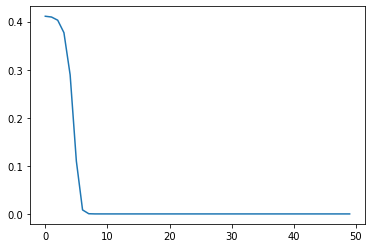

In [8]:
plt.plot(traing_steps, cost_steps)

In [11]:
print(photon_redirection([1.20671364, 0.01]))
print(qubit_rotation(0.5, 0.1))

0.8731983021146449
0.8731983044562817
